C:\Users\adham\AppData\Local\Temp\ipykernel_12772\2615704918.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['total_spend'].fillna(combined_data['total_spend'].mean(), inplace=True)
C:\Users\adham\AppData\Local\Temp\ipykernel_12772\2615704918.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

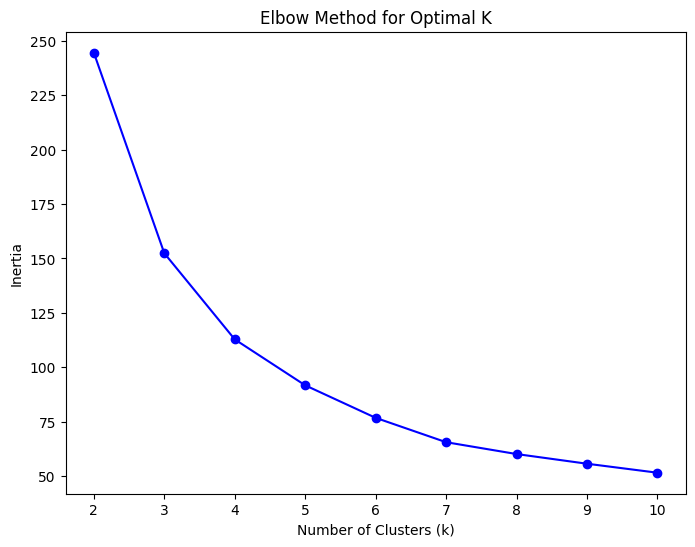

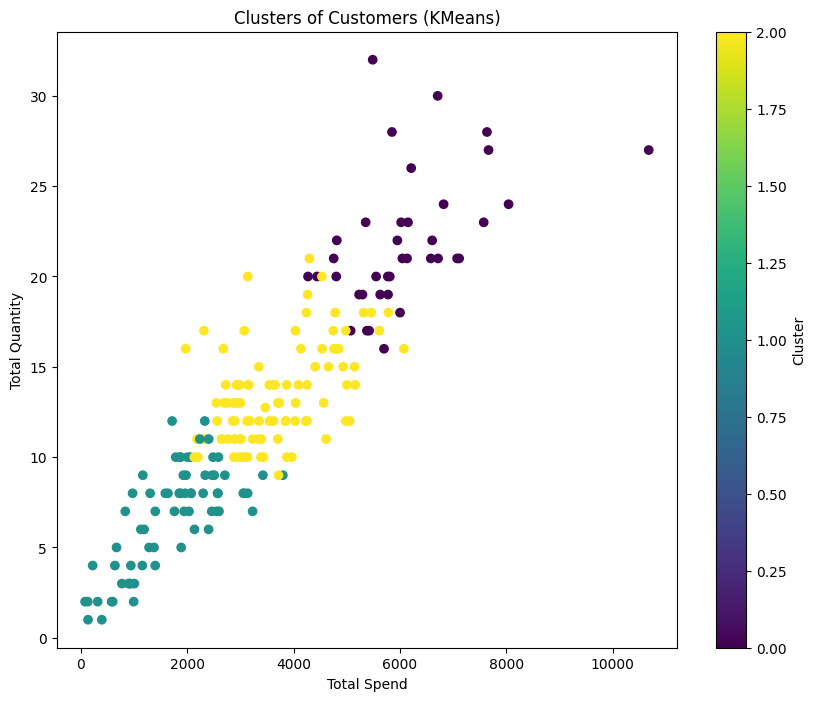

Davies-Bouldin Index: 0.7660470640126223
  CustomerID  total_spend  total_quantity  total_transactions  Cluster
0      C0001      3354.52            12.0                 5.0        2
1      C0002      1862.74            10.0                 4.0        1
2      C0003      2725.38            14.0                 4.0        2
3      C0004      5354.88            23.0                 8.0        0
4      C0005      2034.24             7.0                 3.0        1


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Load the data (use your file paths)
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

# Data Preprocessing
# Add 'SignupDays' to the Customers dataframe (if not already present)
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['SignupDays'] = (pd.to_datetime('today') - customers['SignupDate']).dt.days

# Aggregate the transactions data by CustomerID
customer_transactions = transactions.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    total_transactions=('TransactionID', 'count')
).reset_index()

# Merge customer and transaction data
combined_data = pd.merge(customers[['CustomerID', 'Region', 'SignupDays']], customer_transactions, on='CustomerID', how='left')

# Handling missing values
combined_data['total_spend'].fillna(combined_data['total_spend'].mean(), inplace=True)
combined_data['total_quantity'].fillna(combined_data['total_quantity'].mean(), inplace=True)
combined_data['total_transactions'].fillna(combined_data['total_transactions'].mean(), inplace=True)
combined_data['Region'].fillna(combined_data['Region'].mode()[0], inplace=True)

# One-Hot Encoding for categorical features (Region)
from sklearn.preprocessing import OneHotEncoder

# One-Hot Encoding for categorical features (Region)
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Use sparse_output=False
encoded_region = encoder.fit_transform(combined_data[['Region']])

# Convert the encoded features into a DataFrame
encoded_region_df = pd.DataFrame(encoded_region, columns=encoder.get_feature_names_out(['Region']))

# Concatenate encoded region data with the main dataframe
final_data = pd.concat([combined_data, encoded_region_df], axis=1)


# Standardizing numerical data for KMeans clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_data[['total_spend', 'total_quantity', 'total_transactions']])

# Perform Elbow method to determine the optimal number of clusters
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o', linestyle='-', color='b')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

# Apply KMeans clustering with the optimal number of clusters (let's choose k=3 based on the Elbow method)
kmeans = KMeans(n_clusters=3, random_state=42)
final_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize the clusters using a scatter plot (using two features)
plt.figure(figsize=(10, 8))
plt.scatter(final_data['total_spend'], final_data['total_quantity'], c=final_data['Cluster'], cmap='viridis')
plt.title("Clusters of Customers (KMeans)")
plt.xlabel("Total Spend")
plt.ylabel("Total Quantity")
plt.colorbar(label='Cluster')
plt.show()

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_data, final_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Show the final dataset with clusters
print(final_data[['CustomerID', 'total_spend', 'total_quantity', 'total_transactions', 'Cluster']].head())
